# MEFE 2023: $\text{TP Computacional 1}$
Agustín Brusco

In [2]:
# Importo librerías y defino formato de gráficos
import numpy as np
from scipy.stats import binom, poisson

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Para gráficos de alta resolución
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['legend.fontsize'] = "small"
plt.rcParams['axes.labelsize'] = 'large'

HIST_KWARGS = dict(
    element="bars",
    fill=True,
    alpha=0.75,
    zorder=2,
)
STEM_KWARGS = dict(
    markerfmt="ro",
    basefmt=" ",
    linefmt="k",
    bottom=0,
)
rng = np.random.default_rng(42)  # La respuesta a la pregunta de la vida, el universo y todo lo demás

## 1. Generar Variables de Distribución Uniforme
En Python puede usarse la función `random(n)` de numpy para generar `n` números aleatorios en el intervalo $[0, 1)$ distribuidos uniformemente. Así, para mostar que la probabilidad de obtener un número en el intervalo $[0, p)$ es $p$, puede observarse en una muestra suficientemente grande que aproximadamente $p \cdot n$ de ellos pertenezcan a dicho intervalo (es decir, una fracción $\sim p$ de la muestra pertenece al intervalo). Así, una posible demostración computacional de esta propiedad podría consistir del siguiente experimento:
* Generar $n$ números aleatorios en el intervalo $[0, 1)$ mediante la función `random`.
* Para distintos valores de $p$, contar qué fracción ($f_\mathrm{obs}$) de los $n$ valores generados pertenece al intervalo $[0, p)$ (equivalentemente, la fracción de los valores que es menor a $p$).
* Verificar que la diferencia entre $f_\mathrm{obs}$ y $p$ disminuye para todo $p$ a medida que $n$ aumenta.

Si bien queda demostrado por ser el caso complementario, el mismo experimento puede realizarse para mostrar que la probalidad de que el número pertenezca al intervalo $[p, 1)$ es de $1 - p$.

In [30]:
# Cálculo de las fracciones de valores aleatorios menores que p para distintos tamaños de muestra
size_vals = np.geomspace(10, 1e6, 25, dtype=int)  # 10, 16, 26, ..., 1_000_000
prob_vals = np.linspace(0, 1, 101)  # 0, 0.01, 0.02, ..., 0.99, 1
frac_vals = np.empty((size_vals.size, prob_vals.size))  # Tantas filas como tamaños y tantas columnas como probabilidades
for i, sample_size in enumerate(size_vals):
    random_vals = rng.random(sample_size)
    for j, p in enumerate(prob_vals):
        frac_vals[i, j] = sum(random_vals < p) / sample_size

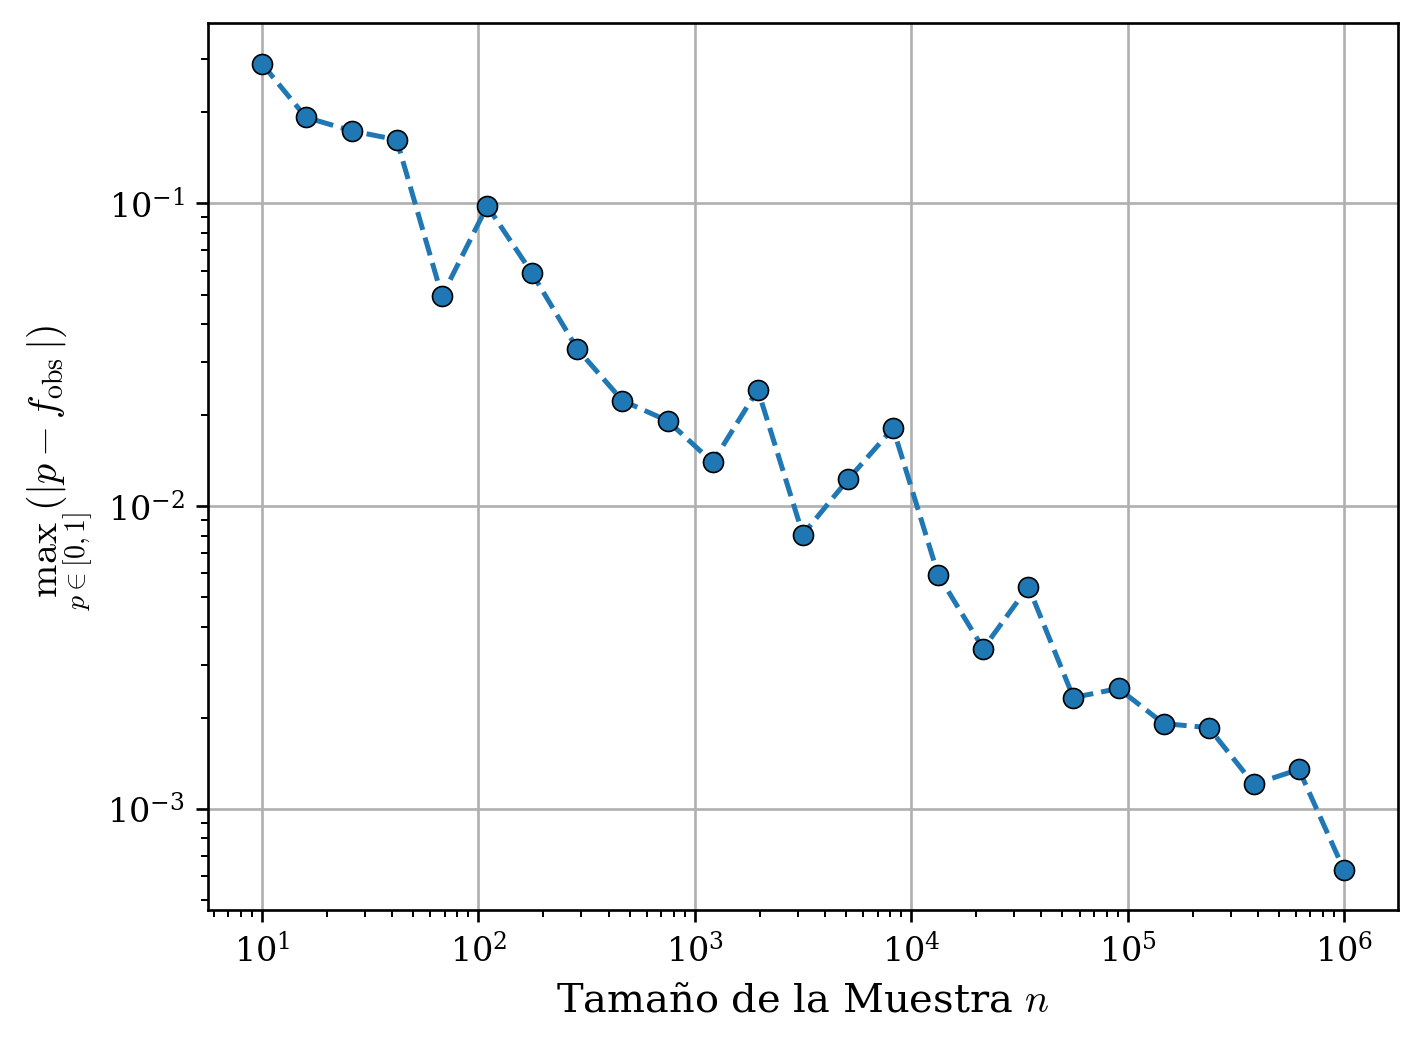

In [31]:
# Máxima diferencia absoluta entre p y f_obs para cada tamaño de muestra
fig, ax = plt.subplots(1, 1)
abs_dif_vals = np.abs(prob_vals - frac_vals)
ax.plot(size_vals, abs_dif_vals.max(axis=1), "o--", mec="k", mew=0.5)
ax.grid()
ax.set_xlabel("Tamaño de la Muestra $n$")
ax.set_ylabel(r"$\max_{p\in[0, 1]}(|p - f_\mathrm{obs}|)$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

De la Figura anterior se puede notar que a medida que aumenta el tamaño de la muestra, el valor absoluto de la diferencia entre $p$ y la frecuencia observada disminuye para todos los valores de $p$ (ya que se observa que el máximo valor de esta diferencia se achica).

In [3]:
def simular_experimentos_bernoulli(n: int, p: float) -> int:
    """Simula `n` experimentos de Bernoulli con probabilidad de éxito `p` \
y devuelve el número de éxitos.
    """
    global rng
    resultados = rng.random(n) < p
    # Notar que esto debe definirse con un < y no con un <=
    # ya que en el caso de que p = 1, el resultado de la comparación
    # debe ser True para cualquier valor de la muestra aleatoria.
    # Analogamente, si p = 0, el resultado de la comparación debe ser False
    # aún si el número aleatorio es 0.
    return resultados.sum()

## 2. Simular Detecciones

In [4]:
n_particulas = 15
eficiencia = 0.75
un_experimento = simular_experimentos_bernoulli(n_particulas, eficiencia)
print(
    f"Incidieron {n_particulas} sobre un detector con eficiencia del {eficiencia:.0%}.",
    f"El resultado fueron {un_experimento} detecciones."
)

Incidieron 15 sobre un detector con eficiencia del 75%. El resultado fueron 8 detecciones.


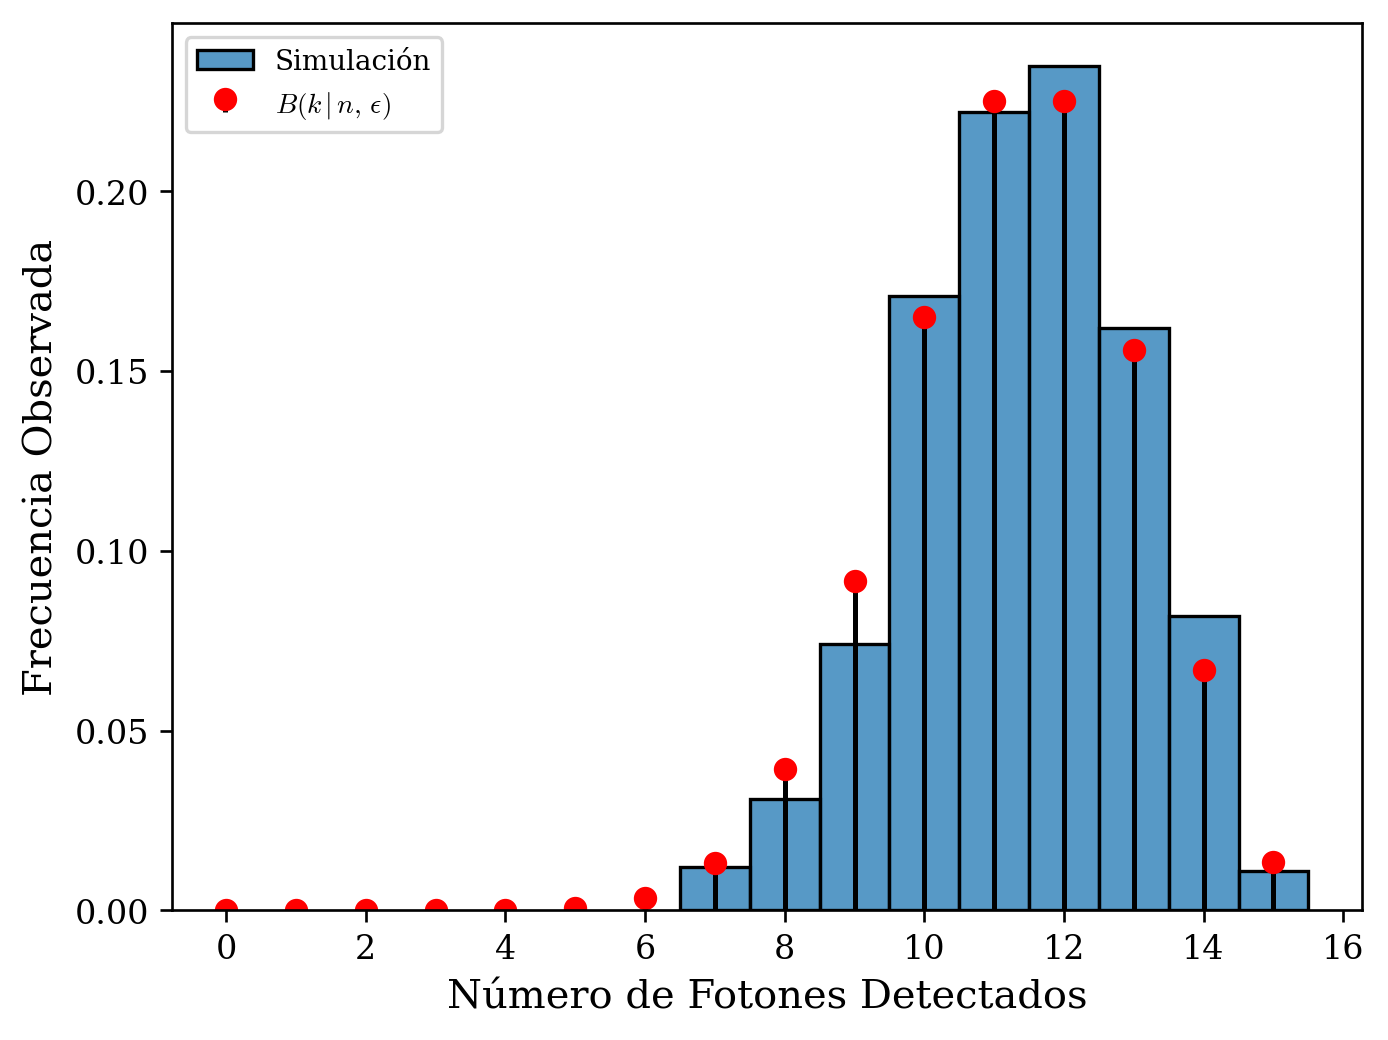

In [11]:
N_experimentos = 1_000
detecciones_por_experimento = np.empty(N_experimentos, dtype=int)
for experimento in range(N_experimentos):
    detecciones_por_experimento[experimento] = simular_experimentos_bernoulli(
        n_particulas, eficiencia
    )

posibles_resultados = np.arange(n_particulas + 1)
distribucion_esperada = binom.pmf(posibles_resultados, n_particulas, eficiencia)
fig, ax = plt.subplots(1, 1)
sns.histplot(
    detecciones_por_experimento,
    ax=ax,
    stat="probability",
    discrete=True,
    **HIST_KWARGS,
    label="Simulación",
)
plt.stem(
    posibles_resultados,
    distribucion_esperada,
    **STEM_KWARGS,
    label=r"$B\left(k\,|\,n,\,\epsilon\right)$",
)
ax.legend(loc="upper left")
ax.set_xlabel("Número de Fotones Detectados")
ax.set_ylabel("Frecuencia Observada")
plt.show()

## 3. Emisiones por Segundo

In [6]:
intensidad_media = 15  # s⁻¹
duracion_experimento = 1  # s
subdivisiones = 1_000
intervalos = np.linspace(0, duracion_experimento, subdivisiones+1)  # s
dt = np.diff(intervalos)[0]  # s
probabilidad_de_emision = intensidad_media * dt
fotones_emitidos = simular_experimentos_bernoulli(subdivisiones, probabilidad_de_emision)
print(f"En un experimento se observaron {fotones_emitidos} fotones.")

En un experimento se observaron 18 fotones.


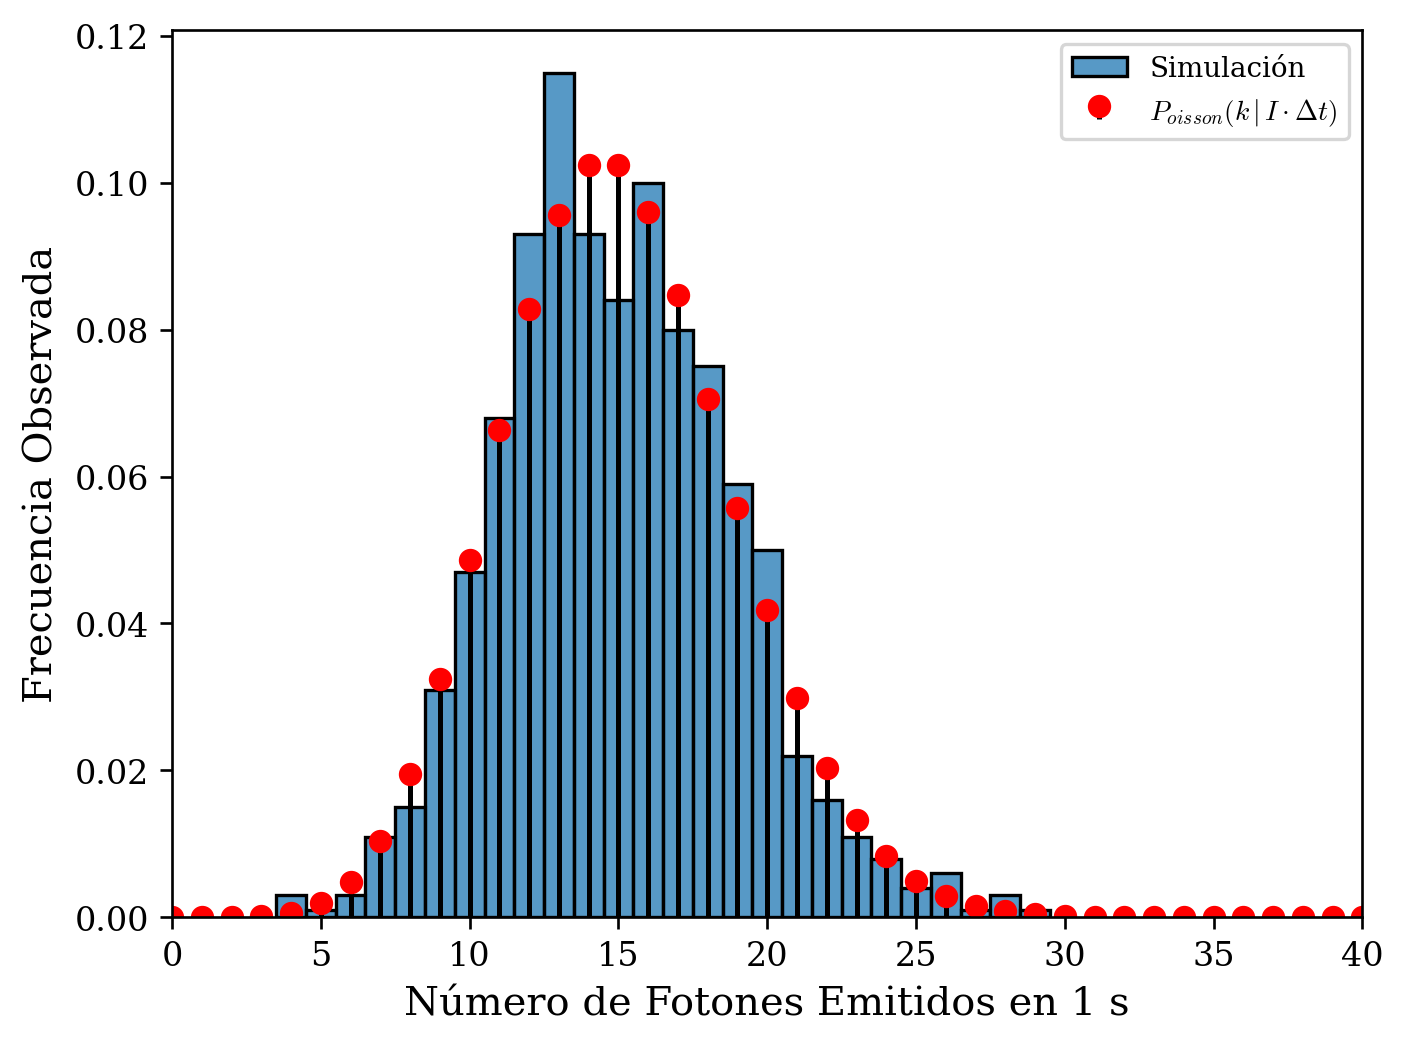

In [7]:
N_experimentos = 1_000
emitidos_por_segundo = np.empty(N_experimentos, dtype=int)
for experimento in range(N_experimentos):
    emitidos_por_segundo[experimento] = simular_experimentos_bernoulli(
        subdivisiones, probabilidad_de_emision
    )

posibles_resultados = np.arange(subdivisiones + 1)
distribucion_esperada = poisson.pmf(
    posibles_resultados, duracion_experimento * intensidad_media
)
fig, ax = plt.subplots(1, 1)
sns.histplot(
    emitidos_por_segundo,
    ax=ax,
    stat="probability",
    discrete=True,
    **HIST_KWARGS,
    label="Simulación",
)
plt.stem(
    posibles_resultados,
    distribucion_esperada,
    **STEM_KWARGS,
    label=r"$P_{oisson}\left(k\,|\,I\cdot\Delta{t}\right)$",
)
ax.legend()
ax.set_xlabel(f"Número de Fotones Emitidos en {duracion_experimento} s")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(0, 40)
plt.show()


## 4. Fotones Detectados

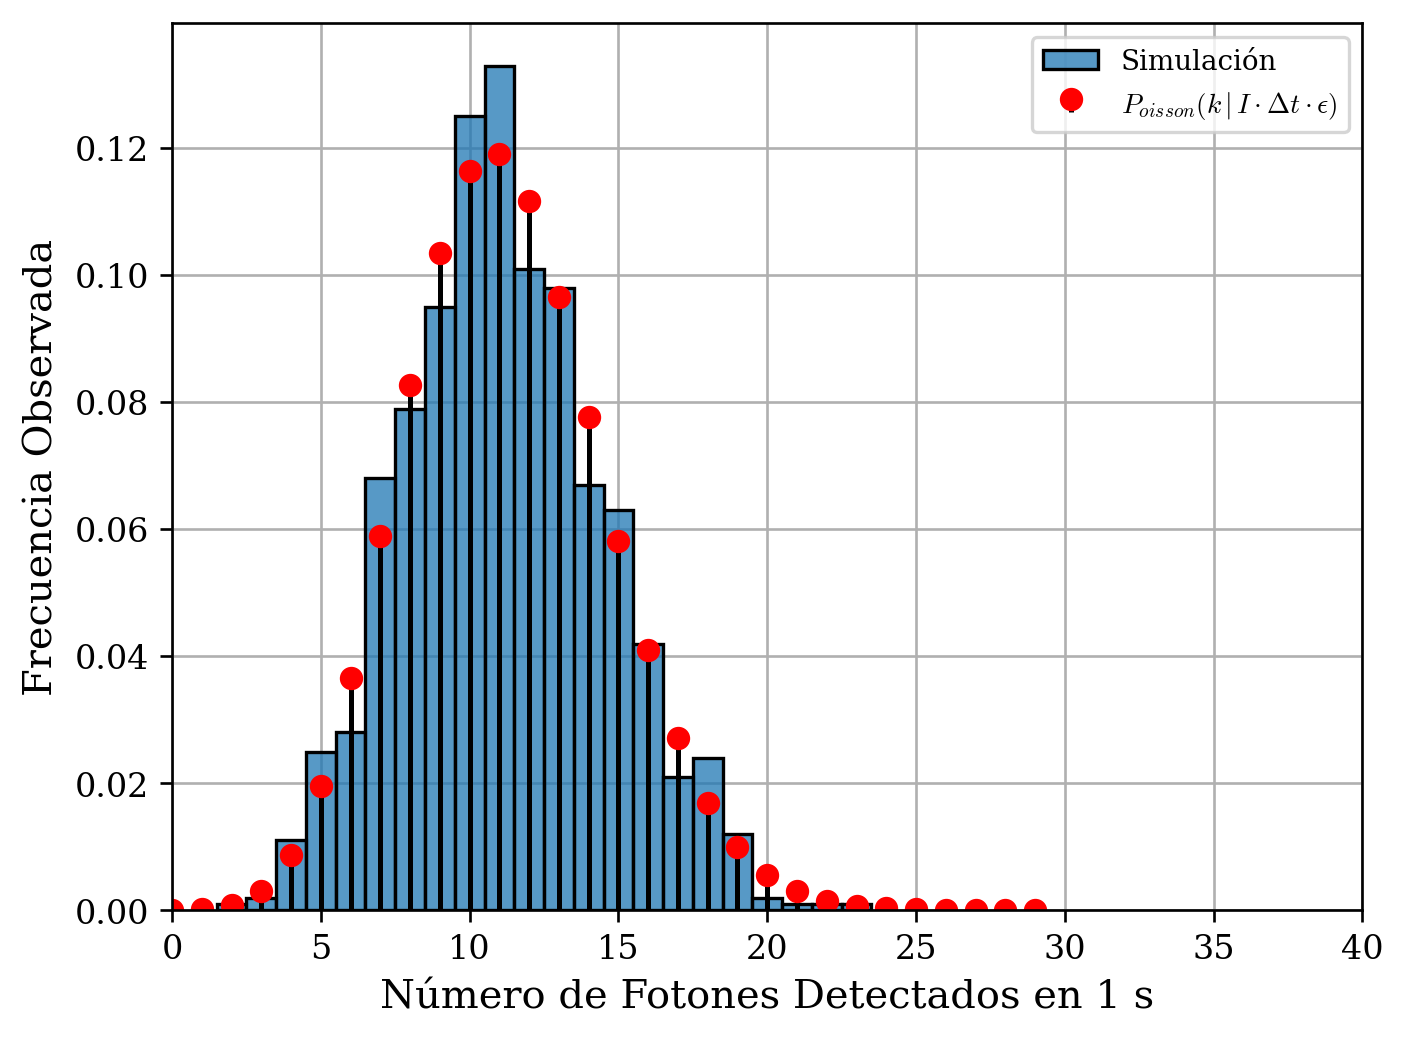

In [8]:
fotones_detectados = np.empty_like(emitidos_por_segundo)
for experimento in range(N_experimentos):
    fotones_detectados[experimento] = simular_experimentos_bernoulli(
        emitidos_por_segundo[experimento], eficiencia
    )

posibles_resultados = np.arange(emitidos_por_segundo.max() + 1)
distribucion_esperada = poisson.pmf(
    posibles_resultados, duracion_experimento * intensidad_media * eficiencia
)
fig, ax = plt.subplots(1, 1)
sns.histplot(
    fotones_detectados,
    ax=ax,
    stat="probability",
    discrete=True,
    **HIST_KWARGS,
    label="Simulación",
)
plt.stem(
    posibles_resultados,
    distribucion_esperada,
    **STEM_KWARGS,
    label=r"$P_{oisson}\left(k\,|\,I\cdot\Delta{t}\cdot\epsilon\right)$",
)
ax.legend()
ax.grid()
ax.set_xlabel(f"Número de Fotones Detectados en {duracion_experimento} s")
ax.set_ylabel("Frecuencia Observada")
ax.set_xlim(0, 40)
plt.show()

## 5. Probabilidad Efectiva

In [ ]:
N_experimentos = 1_000
